In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage.io import ImageCollection
from pprint import pprint
from skimage import io
import numpy as np

In [2]:
def readAllImages(path):
    img_arr = ImageCollection(path + '/*.png')
    return img_arr,len(img_arr)

In [3]:
# 读取数据
blank = readAllImages('''Classify 4/Blank_aug''')
border = readAllImages('''Classify 4/Border_aug''')
center = readAllImages('''Classify 4/Center_aug''')

arr1,len1 = blank[0],blank[1]   # 2
arr2,len2 = border[0],border[1]  # 0
arr3,len3 = center[0],center[1] # 1


y1 = np.full((len1,),2)
y2 = np.zeros((len2,))
y3 = np.ones((len3,))

y_train = np.concatenate([y1,y2,y3])
y_train = y_train.astype('int32')



all_images = []
for i in arr1:
    all_images.append(i)

for i in arr2:
    all_images.append(i)

for i in arr3:
    all_images.append(i)





x_train = np.stack(all_images,axis=0)
print(x_train.shape)
print(y_train.shape)

(1499, 20, 20, 3)
(1499,)


In [4]:
# 数据预处理函数
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32) / 255.
    x = tf.reshape(x, [-1, 32, 32, 3])
    y = tf.one_hot(y, depth=3)  # one_hot 编码
    return x, y

In [5]:
# 样本图像周围补0（上下左右均补6个0），将20*20的图像转成32*32的图像
paddings = tf.constant([[0,0],[6, 6], [6, 6], [0, 0]])
x_train = tf.pad(x_train, paddings)
# x_test = tf.pad(x_test, paddings)

x_train.shape

TensorShape([1499, 32, 32, 3])

In [6]:
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_db = train_db.shuffle(10000)  # 打乱训练集样本
train_db = train_db.batch(128)
train_db = train_db.map(preprocess)

# test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# test_db = test_db.shuffle(10000)  # 打乱测试集样本
# test_db = test_db.batch(128)
# test_db = test_db.map(preprocess)

batch = 32


In [7]:
# 创建模型
model = keras.Sequential([
    # 卷积层1
    keras.layers.Conv2D(6, 5),  # 使用6个5*5的卷积核对单通道32*32的图片进行卷积，结果得到6个28*28的特征图
    keras.layers.MaxPooling2D(pool_size=2, strides=2),  # 对28*28的特征图进行2*2最大池化，得到14*14的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 卷积层2
    keras.layers.Conv2D(16, 5),  # 使用16个5*5的卷积核对6通道14*14的图片进行卷积，结果得到16个10*10的特征图
    keras.layers.MaxPooling2D(pool_size=2, strides=2),  # 对10*10的特征图进行2*2最大池化，得到5*5的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 卷积层3
    keras.layers.Conv2D(120, 5),  # 使用120个5*5的卷积核对16通道5*5的图片进行卷积，结果得到120个1*1的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 将 (None, 1, 1, 120) 的下采样图片拉伸成 (None, 120) 的形状
    keras.layers.Flatten(),
    # 全连接层1
    keras.layers.Dense(84, activation='relu'),  # 120*84
    # 全连接层2
    keras.layers.Dense(3, activation='softmax')  # 84*10
])
model.build(input_shape=(batch, 32, 32, 3))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (32, 28, 28, 6)           456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 14, 14, 6)           0         
_________________________________________________________________
re_lu (ReLU)                 (32, 14, 14, 6)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 10, 10, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 5, 5, 16)            0         
_________________________________________________________________
re_lu_1 (ReLU)               (32, 5, 5, 16)            0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 1, 1, 120)           4

In [8]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# 训练
history = model.fit(train_db, epochs=50)

Epoch 1/50
12/12 [==============================] - 1s 27ms/step - loss: 1.0728 - accuracy: 0.4196
Epoch 2/50
12/12 [==============================] - 0s 29ms/step - loss: 0.8169 - accuracy: 0.6962
Epoch 3/50
12/12 [==============================] - 0s 27ms/step - loss: 0.5286 - accuracy: 0.7187
Epoch 4/50
12/12 [==============================] - 0s 28ms/step - loss: 0.5141 - accuracy: 0.7143
Epoch 5/50
12/12 [==============================] - 0s 30ms/step - loss: 0.5572 - accuracy: 0.7086
Epoch 6/50
12/12 [==============================] - 0s 27ms/step - loss: 0.4343 - accuracy: 0.7895
Epoch 7/50
12/12 [==============================] - 0s 27ms/step - loss: 0.4175 - accuracy: 0.7880
Epoch 8/50
12/12 [==============================] - 0s 31ms/step - loss: 0.3976 - accuracy: 0.7875
Epoch 9/50
12/12 [==============================] - 0s 30ms/step - loss: 0.3879 - accuracy: 0.8121
Epoch 10/50
12/12 [==============================] - 0s 28ms/step - loss: 0.4036 - accuracy: 0.7821
Epoch 11/

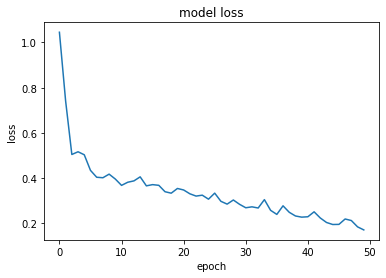

In [9]:
# 损失下降曲线
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [10]:
# # 测试
# model.evaluate(test_db)